## Extra credit assignment

In this homework, you will use two data sets: NYC restaurant inspections and 311 complaints. NYC DOHMH conducts inspections for all restaurants in the city on regular basis and report or take suitable action against the concerned restaurant. You'll use features from the restaurant violations and will check how well these are to predict the 311 complaint types regarding restaurants. You will also use clustering to check which areas are similar in terms of restaurant violations. 

In [200]:
import pandas as pd
import numpy as np
import os
import requests
import zipfile
from datetime import datetime
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist
import statsmodels.formula.api as smf
import urllib
import matplotlib.cm as cm
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=Warning)
%matplotlib inline

### Download restaurant inspections data

other method is to manually download from the website: https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j

In [201]:
## read the data

data = pd.read_csv('/home/jovyan/shared/Data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv', parse_dates=['INSPECTION DATE'])
data.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,50100205,FOUR FOUR SOUTH VILLAGE TAIPEI BEEF NOODLES,Queens,3806,PRINCE ST,11354.0,7183137588,Chinese,2019-11-14,Violations were cited in the following area(s).,...,11/30/2021,Pre-permit (Operational) / Initial Inspection,40.760066,-73.832570,407.0,20.0,87100.0,4439964.0,4.049720e+09,QN22
1,41434246,SILVER KITCHEN,Queens,4301,21 STREET,11101.0,7184331327,American,2018-08-15,Violations were cited in the following area(s).,...,11/30/2021,Cycle Inspection / Re-inspection,40.750557,-73.945718,402.0,26.0,1900.0,4005198.0,4.004410e+09,QN31
2,41139783,JK & SONS COFFEE SHOP,Brooklyn,801,BROADWAY,11206.0,7187822366,American,2018-09-25,Violations were cited in the following area(s).,...,11/30/2021,Cycle Inspection / Re-inspection,40.699713,-73.940137,304.0,34.0,38900.0,3071691.0,3.031320e+09,BK78
3,40394762,CAROLINE'S ON BROADWAY,Manhattan,750,7 AVENUE,10019.0,2127574100,American,2017-10-18,Violations were cited in the following area(s).,...,11/30/2021,Cycle Inspection / Initial Inspection,40.760746,-73.983525,105.0,4.0,12500.0,1024795.0,1.010210e+09,MN17
4,50102980,THE HOLY GROUP,Queens,10402,NORTHERN BLVD,11368.0,9176226465,Other,2021-09-14,Violations were cited in the following area(s).,...,11/30/2021,Pre-permit (Operational) / Initial Inspection,40.757684,-73.864471,403.0,21.0,37900.0,4042649.0,4.017190e+09,QN26


In [202]:
data.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA'],
      dtype='object')

You only need certain columns for the tasks, namely 'CAMIS', 'ZIPCODE', 'INSPECTION DATE', 'ACTION', 'VIOLATION DESCRIPTION', 'SCORE', 'GRADE', 'Latitude', 'Longitude'

'CAMIS' is a unique identifier for a restaurant/business. 'INSPECTION DATE' is the date on which inspection took place. 'ACTION' tells what kind of action was taken, 'VIOLATION DESCRIPTION' is the type of violation reported.

'SCORE' is the measure of severity of violations reported. A higher score means the restaurant had more violations/bad violations. 

'GRADE' is also a measure of restaurant violations. The best grade is 'A' (which means restaurant had minor/no violations), followed by 'B' and 'C', which mean more serious violations. 'P' grade means the inspection is pending and 'N' and 'Z' mean grades was not assigned due to some reasons.

In [203]:
## keep only the above columns
mylist = ['CAMIS', 'ZIPCODE', 'INSPECTION DATE', 'ACTION', 'VIOLATION DESCRIPTION', 'SCORE', 'GRADE', 'Latitude', 'Longitude']
data = data[['CAMIS', 'ZIPCODE', 'INSPECTION DATE', 'ACTION', 'VIOLATION DESCRIPTION', 'SCORE', 'GRADE', 'Latitude', 'Longitude']]
data

,CAMIS,ZIPCODE,INSPECTION DATE,ACTION,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude
0,50100205,11354.0,2019-11-14,Violations were cited in the following area(s).,Pesticide use not in accordance with label or ...,2.0,NaN,40.760066,-73.832570
1,41434246,11101.0,2018-08-15,Violations were cited in the following area(s).,Facility not vermin proof. Harborage or condit...,44.0,C,40.750557,-73.945718
2,41139783,11206.0,2018-09-25,Violations were cited in the following area(s).,Facility not vermin proof. Harborage or condit...,25.0,B,40.699713,-73.940137
3,40394762,10019.0,2017-10-18,Violations were cited in the following area(s).,Plumbing not properly installed or maintained;...,15.0,NaN,40.760746,-73.983525
4,50102980,11368.0,2021-09-14,Violations were cited in the following area(s).,Cold food item held above 41º F (smoked fish a...,17.0,N,40.757684,-73.864471
...,...,...,...,...,...,...,...,...,...
383166,50074863,11421.0,2018-04-26,Violations were cited in the following area(s).,Non-food contact surface improperly constructe...,10.0,NaN,40.691327,-73.867033
383167,50074863,11421.0,2018-04-26,Violations were cited in the following area(s).,Non-food contact surface improperly constructe...,10.0,NaN,40.691327,-73.867033
383168,50074863,11421.0,2018-04-26,Violations were cited in the following area(s).,Non-food contact surface improperly constructe...,10.0,NaN,40.691327,-73.867033
383169,40369017,10017.0,2019-09-10,Violations were cited in the following area(s).,Cold food item held above 41º F (smoked fish a...,31.0,NaN,40.751554,-73.970927


In [204]:
data.shape

(383171, 9)

### Keep data only for 2019

In [205]:
data['INSPECTION DATE'] = pd.to_datetime(data['INSPECTION DATE'])
data['Year'] = data['INSPECTION DATE'].dt.year
data2019 = data.loc[data['Year'] == 2019]
data2019

,CAMIS,ZIPCODE,INSPECTION DATE,ACTION,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude,Year
0,50100205,11354.0,2019-11-14,Violations were cited in the following area(s).,Pesticide use not in accordance with label or ...,2.0,NaN,40.760066,-73.832570,2019
10,50062800,10029.0,2019-09-17,Violations were cited in the following area(s).,Food Protection Certificate not held by superv...,29.0,NaN,40.786669,-73.950325,2019
12,41014435,10009.0,2019-04-02,Establishment Closed by DOHMH. Violations were...,Food not protected from potential source of co...,71.0,NaN,40.721471,-73.980154,2019
14,41227024,11374.0,2019-11-19,Violations were cited in the following area(s).,Non-food contact surface improperly constructe...,13.0,A,40.727510,-73.864020,2019
15,41227024,11374.0,2019-11-19,Violations were cited in the following area(s).,Non-food contact surface improperly constructe...,13.0,A,40.727510,-73.864020,2019
...,...,...,...,...,...,...,...,...,...,...
383160,50071749,11354.0,2019-02-13,Establishment Closed by DOHMH. Violations were...,Food from unapproved or unknown source or home...,52.0,NaN,40.763531,-73.829688,2019
383162,50066476,11372.0,2019-06-27,Violations were cited in the following area(s).,Hot food item not held at or above 140º F.,26.0,B,40.747173,-73.891484,2019
383163,41194745,NaN,2019-01-29,Violations were cited in the following area(s).,"Sanitized equipment or utensil, including in-u...",12.0,A,0.000000,0.000000,2019
383164,50071464,11373.0,2019-10-31,Violations were cited in the following area(s).,Non-food contact surface improperly constructe...,21.0,NaN,40.742469,-73.873069,2019


In [206]:
data2019.shape

(145583, 10)

### Remove rows where the 'ACTION' was restaurant closure: 'Establishment Closed by DOHMH.  Violations were cited in the following area(s) and those requiring immediate action were addressed.' and 'Establishment re-closed by DOHMH'

In [207]:
data1 = data2019.loc[data2019['ACTION'].isin(['Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.'])]
data1.shape

(5890, 10)

In [208]:
data2 = data2019.loc[data2019['ACTION'].isin(['Establishment re-closed by DOHMH'])]
data2.shape 
# There is no rows for 'Establishment re-closed by DOHMH'.

(0, 10)

In [209]:
df = data2019.loc[~data2019['ACTION'].isin(['Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.'])]
df.shape

(139693, 10)

In [210]:
print(data2019.shape[0]-df.shape[0])

5890


### You only need certain type of violations for further analysis. Keep only the rows where 'VIOLATION DESCRIPTION' was one of the below categories

In [211]:
violCat = pd.read_csv('RestViol_types.csv')
violCat.head()

,VIOLATION DESCRIPTION,count
0,Facility not vermin proof. Harborage or condit...,41352
1,Evidence of mice or live mice present in facil...,27816
2,"Food contact surface not properly washed, rins...",25889
3,Food not protected from potential source of co...,25336
4,Cold food item held above 41Âº F (smoked fish ...,22834


In [212]:
# keep rows just for above categories

#data = data[data['VIOLATION DESCRIPTION'].isin(violCat['VIOLATION DESCRIPTION'])]
#data.shape
df = df[df['VIOLATION DESCRIPTION'].isin(violCat['VIOLATION DESCRIPTION'])]
df.shape

(62738, 10)

### Filter out GRADES that are 'P', 'N' and 'Z'

Do not remove the NaN values from 'GRADE' yet

In [213]:
data.GRADE.unique()

array([nan, 'C', 'B', 'N', 'A', 'P', 'Z', 'G'], dtype=object)

In [214]:
ldata3 = df.loc[df['GRADE'].isin(['P','N','Z'])]
data3.shape

(751, 10)

In [215]:
df1 = df.loc[~df['GRADE'].isin(['P','N','Z'])]
df1.shape

(61987, 10)

In [216]:
print(df.shape[0]-df1.shape[0])

751


Zip codes shapefile

In [217]:
!git clone https://github.com/CUSP2020PUI/Data.git

zips = gpd.read_file("Data/zip_code/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

Cloning into 'Data'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
fatal: write error: No space left on device
fatal: index-pack failed


DriverError: Data/zip_code/ZIP_CODE_040114.shp: No such file or directory

In [218]:
# or use this
urllib.request.urlretrieve ("https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip", 
                            "ZIPS.zip")
with zipfile.ZipFile('ZIPS.zip', 'r') as zip_ref:
    zip_ref.extractall('ZIPS/')
    
zips = gpd.read_file("ZIPS/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,POPULATION,geometry
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,83866.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,56527.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,72280.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


### Merge the violations data with zip code shapefile on column 'ZIPCODE'

In [219]:
df1.head()

,CAMIS,ZIPCODE,INSPECTION DATE,ACTION,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude,Year
24,50093646,11366.0,2019-08-07,Violations were cited in the following area(s).,Proper sanitization not provided for utensil w...,11.0,A,40.729259,-73.780988,2019
28,41527419,11426.0,2019-07-29,Violations were cited in the following area(s).,Facility not vermin proof. Harborage or condit...,33.0,NaN,40.735411,-73.717189,2019
29,50057988,10013.0,2019-01-15,Violations were cited in the following area(s).,Proper sanitization not provided for utensil w...,9.0,A,40.714309,-73.997929,2019
39,41617404,10467.0,2019-04-16,Violations were cited in the following area(s).,Food worker does not wash hands thoroughly aft...,20.0,NaN,40.863596,-73.864999,2019
54,50066837,11205.0,2019-06-29,Violations were cited in the following area(s).,Facility not vermin proof. Harborage or condit...,30.0,NaN,40.691625,-73.971123,2019


In [220]:
df1.dtypes

CAMIS                             int64
ZIPCODE                         float64
INSPECTION DATE          datetime64[ns]
ACTION                           object
VIOLATION DESCRIPTION            object
SCORE                           float64
GRADE                            object
Latitude                        float64
Longitude                       float64
Year                              int64
dtype: object

In [221]:
zips.dtypes

ZIPCODE          int64
POPULATION     float64
geometry      geometry
dtype: object

In [222]:
res = zips.merge(df1,on='ZIPCODE',how='left')
res.head()
res.shape

(63385, 12)

### Next, you need to aggregare features by zipcode. You need to get number of violations, average score, and ratio of each grade 'A', 'B' and 'C'. The ratio for a particular grade 'A' should be calculated as number of inspections when restaurants were graded 'A' divided by total number of inspections. In the end, you should have 5 above featues for each zip code.

In [248]:
# get number of violations and average score
viosco = res[['ZIPCODE', 'CAMIS', 'SCORE']].groupby(by='ZIPCODE').agg({'SCORE': 'mean', 'CAMIS': 'count'})
viosco = viosco.rename(columns = {'CAMIS':'violations'})
viosco

,SCORE,violations
ZIPCODE,,
83,NaN,0
10001,19.870285,1087
10002,21.900662,1512
10003,19.778047,1650
10004,22.167702,1292
...,...,...
11691,20.218391,87
11692,14.062500,16
11693,18.384615,260


In [249]:
## get each grade ratio per zip code

In [250]:
res.columns

Index(['ZIPCODE', 'POPULATION', 'geometry', 'CAMIS', 'INSPECTION DATE',
       'ACTION', 'VIOLATION DESCRIPTION', 'SCORE', 'GRADE', 'Latitude',
       'Longitude', 'Year'],
      dtype='object')

In [251]:
# Grade
grade = res.groupby(['ZIPCODE','GRADE']).agg({'CAMIS':'count'}).reset_index()
grade.head()

,ZIPCODE,GRADE,CAMIS
0,10001,A,473
1,10001,B,72
2,10001,C,18
3,10002,A,516
4,10002,B,144


In [252]:
total = res.groupby(['ZIPCODE']).agg({'CAMIS':'count'}).reset_index()
#total = total[1:]
total.head(3)

,ZIPCODE,CAMIS
0,83,0
1,10001,1087
2,10002,1512


In [253]:
# A
A = grade.loc[grade['GRADE'] == 'A']
A.head(3)

,ZIPCODE,GRADE,CAMIS
0,10001,A,473
3,10002,A,516
6,10003,A,646


In [254]:
A['RATIOofA'] = A.apply(lambda x: x['CAMIS'] / 
                                                 total.loc[total['ZIPCODE']==x['ZIPCODE']]['CAMIS'].values[0],axis = 1)

A = A.rename(columns = {'GRADE':'A'})
A = A.drop('CAMIS', axis = 1)
A.head(3)

,ZIPCODE,A,RATIOofA
0,10001,A,0.435143
3,10002,A,0.341270
6,10003,A,0.391515


In [255]:
# B
B = grade.loc[grade['GRADE'] == 'B']
B['RATIOofB'] = B.apply(lambda x: x['CAMIS'] / 
                                                 total.loc[total['ZIPCODE']==x['ZIPCODE']]['CAMIS'].values[0],axis = 1)
B = B.rename(columns = {'GRADE':'B'})
B = B.drop('CAMIS', axis = 1)
B.head(3)

,ZIPCODE,B,RATIOofB
1,10001,B,0.066237
4,10002,B,0.095238
7,10003,B,0.089091


In [256]:
# C
C = grade.loc[grade['GRADE'] == 'C']
C['RATIOofC'] = C.apply(lambda x: x['CAMIS'] / 
                                                 total.loc[total['ZIPCODE']==x['ZIPCODE']]['CAMIS'].values[0],axis = 1)
C = C.rename(columns = {'GRADE':'C'})
C = C.drop('CAMIS', axis = 1)
C.head(3)

,ZIPCODE,C,RATIOofC
2,10001,C,0.016559
5,10002,C,0.029101
8,10003,C,0.024242


In [257]:
## merge number of violations, avg score and grade ratios 
Three = viosco.merge(A, on = 'ZIPCODE', how = 'left')
Three.head(3)

,ZIPCODE,SCORE,violations,A,RATIOofA
0,83,NaN,0,NaN,NaN
1,10001,19.870285,1087,A,0.435143
2,10002,21.900662,1512,A,0.341270


In [258]:
four = Three.merge(B, on = 'ZIPCODE', how = 'left')
four.head(3)

,ZIPCODE,SCORE,violations,A,RATIOofA,B,RATIOofB
0,83,NaN,0,NaN,NaN,NaN,NaN
1,10001,19.870285,1087,A,0.435143,B,0.066237
2,10002,21.900662,1512,A,0.341270,B,0.095238


In [259]:
five = four.merge(C, on = 'ZIPCODE', how = 'left')
five = five.drop(['A','B','C'], axis = 1)
five.head(3)

,ZIPCODE,SCORE,violations,RATIOofA,RATIOofB,RATIOofC
0,83,NaN,0,NaN,NaN,NaN
1,10001,19.870285,1087,0.435143,0.066237,0.016559
2,10002,21.900662,1512,0.341270,0.095238,0.029101


In [260]:
five['RATIOofB'].unique

<bound method Series.unique of 0           NaN
1      0.066237
2      0.095238
3      0.089091
4      0.046440
         ...   
243    0.080460
244         NaN
245    0.046154
246         NaN
247    0.333333
Name: RATIOofB, Length: 248, dtype: float64>

### Read 311 data.

This data containts all restaurant related complaints for 2019. 'Unique Key' is a unique identifier for each complaint

In [261]:
data311 = pd.read_csv('311_foodComplaints.csv')
data311.head()

,Unique Key,Incident Zip,Complaint Type,Descriptor
0,34057077,10020.0,Food Establishment,Dishwashing/Utensils
1,34057113,11104.0,Food Poisoning,1 or 2
2,34057299,10027.0,Food Establishment,Rodents/Insects/Garbage
3,34057325,10017.0,Food Establishment,Bare Hands in Contact w/ Food
4,34057330,11385.0,Food Establishment,Bare Hands in Contact w/ Food


In [262]:
data311.shape

(22388, 4)

### Group these 311 complaints by zip code

In [263]:
zip311 = data311.groupby(['Incident Zip']).agg({'Unique Key':'count'}).reset_index()
zip311 = zip311.rename(columns={'Unique Key':'Complaints'})
zip311 = zip311[2:]
zip311.head(3)

,Incident Zip,Complaints
2,10000.0,2
3,10001.0,331
4,10002.0,348


In [264]:
## merge with zips shapefile and normalize 311 complaints by population (per 1000 people)
geo311 = zip311.merge(zips, left_on = 'Incident Zip', right_on = 'ZIPCODE')
geo311 = geo311.drop(['Incident Zip'], axis = 1)
geo311.head(3)

,Complaints,ZIPCODE,POPULATION,geometry
0,331,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,348,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,505,10003,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20..."


In [265]:
## merge with the violations features data from above
mergedf = geo311.merge(five)
mergedf.head(3)

,Complaints,ZIPCODE,POPULATION,geometry,SCORE,violations,RATIOofA,RATIOofB,RATIOofC
0,331,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",19.870285,1087,0.435143,0.066237,0.016559
1,348,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",21.900662,1512,0.341270,0.095238,0.029101
2,505,10003,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",19.778047,1650,0.391515,0.089091,0.024242


### Normalize the number of 311 complaints and number of violations by population (per 1000 people)

In [266]:
mergedf['compnorm'] = mergedf['Complaints']/mergedf['POPULATION']*1000
mergedf['vionorm'] = mergedf['violations']/mergedf['POPULATION']*1000
mergedf.head(3)

,Complaints,ZIPCODE,POPULATION,geometry,SCORE,violations,RATIOofA,RATIOofB,RATIOofC,compnorm,vionorm
0,331,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",19.870285,1087,0.435143,0.066237,0.016559,14.768215,48.498639
1,348,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",21.900662,1512,0.341270,0.095238,0.029101,4.280180,18.596642
2,505,10003,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",19.778047,1650,0.391515,0.089091,0.024242,9.037546,29.528616


In [267]:
mergedf.shape

(222, 11)

In [268]:
# check statistics of all features
mergedf.describe()

,Complaints,ZIPCODE,POPULATION,SCORE,violations,RATIOofA,RATIOofB,RATIOofC,compnorm,vionorm
count,222.000000,222.000000,222.000000,214.000000,222.000000,212.000000,181.000000,153.000000,222.000000,214.000000
mean,104.256757,10737.400901,37829.734234,19.290077,316.018018,0.452686,0.079864,0.039364,inf,inf
std,98.934742,587.596451,28920.821732,3.452114,334.964386,0.142428,0.044738,0.033598,NaN,NaN
min,1.000000,10001.000000,0.000000,6.500000,0.000000,0.260870,0.007752,0.004202,0.170940,0.512821
25%,28.000000,10119.500000,12351.250000,18.222810,72.000000,0.381593,0.050420,0.021569,1.514168,3.508275
50%,76.000000,10471.500000,35223.500000,19.589863,232.000000,0.417765,0.074627,0.029412,2.671713,6.585415
75%,144.750000,11354.750000,58450.500000,21.352765,400.750000,0.470798,0.093023,0.046429,5.519363,16.408732
max,505.000000,11697.000000,109069.000000,31.000000,1650.000000,1.000000,0.333333,0.285714,inf,inf


In [269]:
## keep only rows where normalized 311 complaints (per 1000 people) are <30
mergedf = mergedf[mergedf['compnorm'] <30]
mergedf.head(3)

,Complaints,ZIPCODE,POPULATION,geometry,SCORE,violations,RATIOofA,RATIOofB,RATIOofC,compnorm,vionorm
0,331,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",19.870285,1087,0.435143,0.066237,0.016559,14.768215,48.498639
1,348,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",21.900662,1512,0.341270,0.095238,0.029101,4.280180,18.596642
2,505,10003,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",19.778047,1650,0.391515,0.089091,0.024242,9.037546,29.528616


In [270]:
mergedf.shape

(189, 11)

### Visualization

Plot normalized number of violations, average score and normalized 311 complaints on separate maps 

In [271]:
geodf = gpd.GeoDataFrame(mergedf, geometry = 'geometry')
geodf.head(3)

,Complaints,ZIPCODE,POPULATION,geometry,SCORE,violations,RATIOofA,RATIOofB,RATIOofC,compnorm,vionorm
0,331,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",19.870285,1087,0.435143,0.066237,0.016559,14.768215,48.498639
1,348,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",21.900662,1512,0.341270,0.095238,0.029101,4.280180,18.596642
2,505,10003,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",19.778047,1650,0.391515,0.089091,0.024242,9.037546,29.528616


In [272]:
geodf['RATIOofC'].unique

<bound method Series.unique of 0      0.016559
1      0.029101
2      0.024242
7      0.026316
8      0.041237
         ...   
217         NaN
218         NaN
219         NaN
220         NaN
221         NaN
Name: RATIOofC, Length: 189, dtype: float64>

<AxesSubplot:>

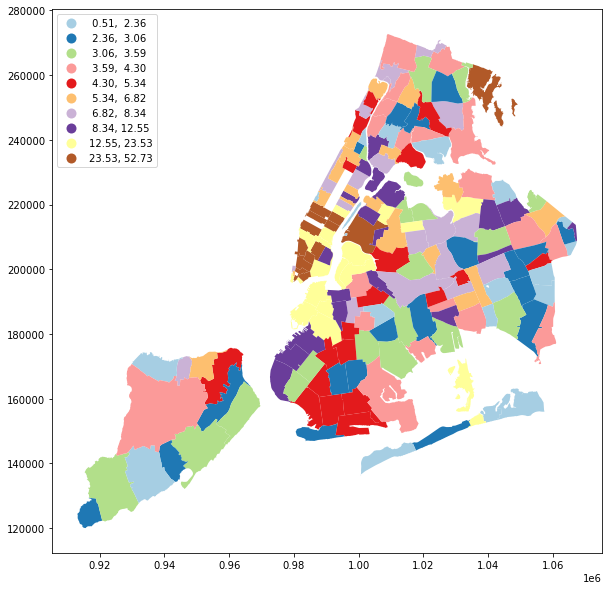

In [273]:
## normalized number of violations (per 1000 people)
geodf.plot(column = 'vionorm', k = 10, scheme = 'Quantiles', legend = True,
           legend_kwds = {'loc':'upper left'}, cmap = 'Paired', figsize = (10,10))


<AxesSubplot:>

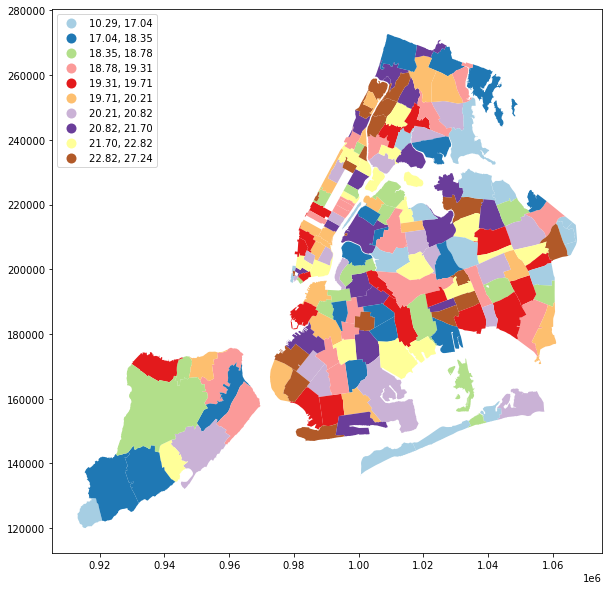

In [274]:
## average score
geodf.plot(column = 'SCORE', k = 10, scheme = 'Quantiles', legend = True,
           legend_kwds = {'loc':'upper left'}, cmap = 'Paired', figsize = (10,10))

<AxesSubplot:>

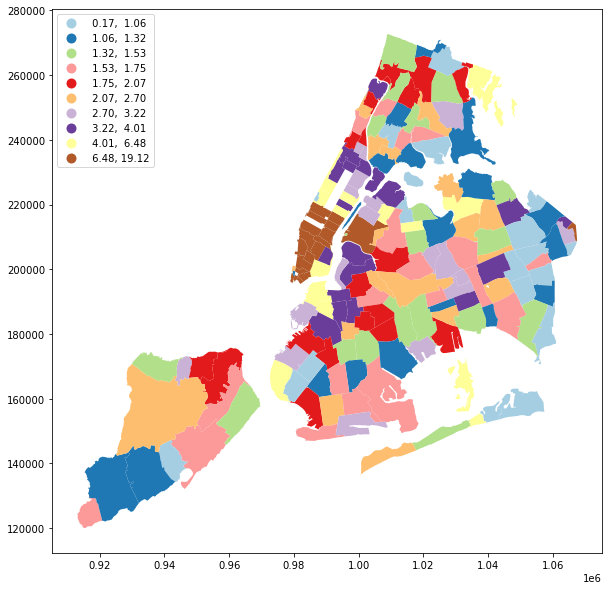

In [275]:
## normalized 311 complaints (per 1000 people)
geodf.plot(column = 'compnorm', k = 10, scheme = 'Quantiles', legend = True,
           legend_kwds = {'loc':'upper left'}, cmap = 'Paired', figsize = (10,10))

### Perform clustering analyses by assigning each zipcode to a cluster. Use K-means clustering and choose appropriate number of clusters with average silhouette score and visualize the clusters on the map.

Take only the following features: normalized number of violations, average score and ratios for each grade for the task

These features make an approximate profile of a neighborhood in terms of the quality and performance of restaurants and food businesses present there. With clustering, we would get an idea about what areas have similar profiles and would help understand the areas where restaurants behave similarly. 

Make sure to standardize the data before clustering

In [276]:
## perform clustring analyses
ml = ['vionorm','SCORE', 'RATIOofA','RATIOofB','RATIOofC']
new = geodf[ml]
new = new.dropna()
new

,vionorm,SCORE,RATIOofA,RATIOofB,RATIOofC
0,48.498639,19.870285,0.435143,0.066237,0.016559
1,18.596642,21.900662,0.341270,0.095238,0.029101
2,29.528616,19.778047,0.391515,0.089091,0.024242
7,14.061922,18.535088,0.500000,0.052632,0.026316
8,32.215211,20.247423,0.381443,0.051546,0.041237
...,...,...,...,...,...
209,7.426500,20.349241,0.425163,0.086768,0.032538
210,1.425220,18.729167,0.416667,0.062500,0.041667
211,3.121282,19.375691,0.458564,0.038674,0.055249
212,5.711183,18.828947,0.409836,0.085246,0.019672


In [277]:
## use average silhouette score (just report the scores and choose best for number of clusters to be used)
## try with (3-15 clusters)

for n_clusters in range(3,16):
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(new)
    silhouette_avg = silhouette_score(new, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =3, the average silhouette_score is :0.5830619948236486
For n_clusters =4, the average silhouette_score is :0.5812817289877992
For n_clusters =5, the average silhouette_score is :0.4510892000014944
For n_clusters =6, the average silhouette_score is :0.4222762968674394
For n_clusters =7, the average silhouette_score is :0.4283791128027005
For n_clusters =8, the average silhouette_score is :0.43237359064882624
For n_clusters =9, the average silhouette_score is :0.4011631274813234
For n_clusters =10, the average silhouette_score is :0.396327415858354
For n_clusters =11, the average silhouette_score is :0.3942057048146722
For n_clusters =12, the average silhouette_score is :0.40988687341763064
For n_clusters =13, the average silhouette_score is :0.40313043411694444
For n_clusters =14, the average silhouette_score is :0.41576056515684623
For n_clusters =15, the average silhouette_score is :0.39568988740862554


<AxesSubplot:>

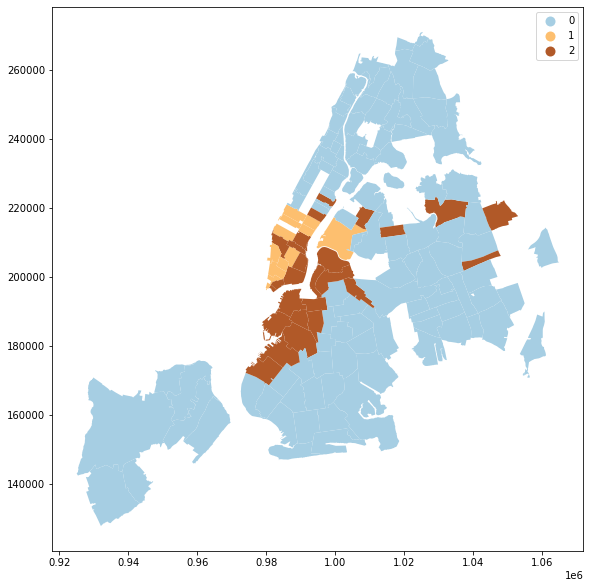

In [278]:
## plot all clustered zips in the map
geodf = geodf.dropna()
model = KMeans(n_clusters=3, random_state=324).fit(geodf[ml])
geodf['label'] = model.predict(geodf[ml]).astype(str)

geodf.plot(column='label', legend = True, figsize=(10,10), cmap = 'Paired')

### Perform a regression analyses with normalized 311 complaints as the target and above features (normalized number of violations, average score, and ratios of 'A', 'B' and 'C' grades) as regressors. Comment on the signficance of each feature.

Include the intercept for the regression analysis. Try performing regression with each of the regressors individually (with normalized 311 complaints as target). Comment on how these regressor perform against each other. What do you think could be any problems when doing regression with all regressors together? Also comment on the coeffiecients of each regressor and whether or not they are significant.

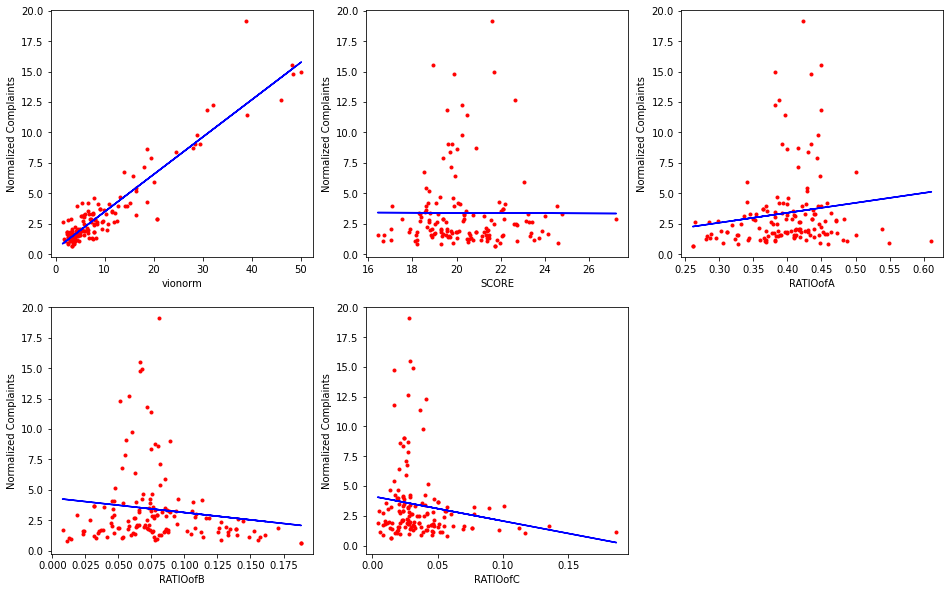

In [279]:
plt.figure(figsize = (16,10))
pList = {}
for i, j in enumerate(ml):
    plt.subplot(230+i+1)
    lm = smf.ols(formula = 'compnorm ~ ' + j, data = geodf).fit()
    plt.plot(geodf[j],geodf['compnorm'],'.r')
    plt.plot(geodf[j],lm.predict(),'b')
    plt.xlabel(j)
    plt.ylabel('Normalized Complaints')
    pList[j] = lm.pvalues[j]

In [280]:
pList
# normalized violation and ration of grade C are significant

{'vionorm': 2.1634417513036563e-66,
 'SCORE': 0.9604086418512424,
 'RATIOofA': 0.08024861494631318,
 'RATIOofB': 0.10540973998195012,
 'RATIOofC': 0.04842083922761073}

In [281]:
lm = smf.ols(formula = 'compnorm ~ ' +'+'.join(ml), data = geodf).fit()
lm.pvalues

Intercept    2.781262e-02
vionorm      1.076952e-64
SCORE        5.853186e-02
RATIOofA     1.498693e-02
RATIOofB     6.143028e-01
RATIOofC     6.559278e-01
dtype: float64

In [282]:
# Intercept, normalized violations and ratio of grade A are significant.
# when doing regression with all regressors together, regressors will influence each other because of correlation.